# "Ultimate" take home challenge part 1 
Ride share company

**Instructions:**
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. 
* Aggregate these login counts based on 15 minute
time intervals, 
* visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. 
* Please report/illustrate important features of the demand,
such as daily cycles. 
* If there are data quality issues, please report them.

In [62]:
# Imports
import numpy as np
import pandas as pd
import json
from datetime import datetime
from matplotlib.dates import DateFormatter
import seaborn as sns
import matplotlib.pyplot as plt

## Read file, quick look, aggregation

In [43]:
# import
with open("logins.json") as login_file:
    raw_logins = json.load(login_file)

In [44]:
# review
print(raw_logins.keys())
print(len(raw_logins['login_time']))
raw_logins['login_time'][:10]

dict_keys(['login_time'])
93142


['1970-01-01 20:13:18',
 '1970-01-01 20:16:10',
 '1970-01-01 20:16:37',
 '1970-01-01 20:16:36',
 '1970-01-01 20:26:21',
 '1970-01-01 20:21:41',
 '1970-01-01 20:12:16',
 '1970-01-01 20:35:47',
 '1970-01-01 20:35:38',
 '1970-01-01 20:47:52']

Year 1970? Seems suspicious

In [45]:
# Convert to dateTime objects
# correct conversion:
#datetime.strptime('1970-01-01 20:13:18', '%Y-%m-%d %H:%M:%S')
# use pandas, slight overhead but small enough data set and useful enough tools
logins_df = pd.DataFrame(raw_logins)
logins_df["login_time"] = pd.to_datetime(logins_df["login_time"])
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [46]:
logins_df = logins_df.set_index('login_time')

In [47]:
# aggregate into 15 min intervals
# make dummy column to count each entry as 1
logins_df['logins_count'] = 1
# do aggregation, sum or count
logins_15min_df = logins_df.resample('15min', label='right').sum()
display(logins_15min_df.head(5))
display(logins_15min_df.describe())

,logins_count
login_time,
1970-01-01 20:15:00,2
1970-01-01 20:30:00,6
1970-01-01 20:45:00,9
1970-01-01 21:00:00,7
1970-01-01 21:15:00,1


,logins_count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


In [48]:
logins_df['logins_count'] = 1
# do aggregation, sum or count
logins_daily_df = logins_df.resample('D', label='right').sum()
logins_daily_df["is_weekend"] = logins_daily_df.index.dayofweek > 5
logins_daily_df.describe()

,logins_count
count,103.000000
mean,904.291262
std,347.167463
min,112.000000
25%,643.000000
50%,827.000000
75%,1141.000000
max,1889.000000


## Viz and description

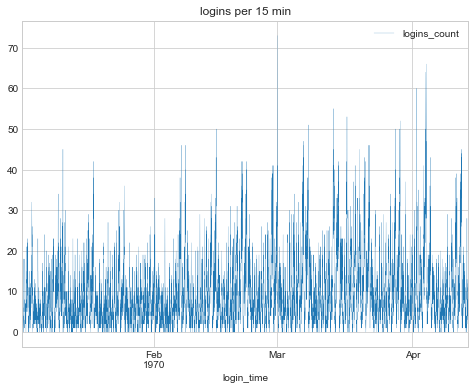

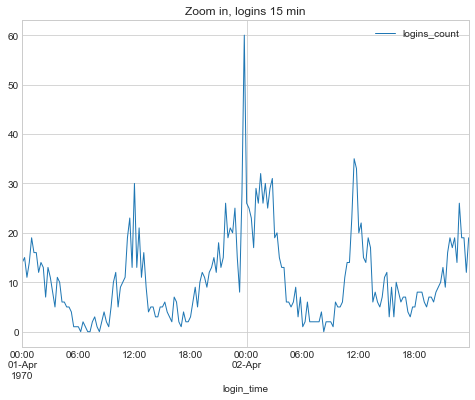

In [49]:
#set size for all future plots and this one
plt.rcParams["figure.figsize"] = (8,6)

#plt.style.use('fivethirtyeight')
plt.style.use('seaborn-whitegrid')
logins_15min_df.plot(title="logins per 15 min", linewidth=0.2);
logins_15min_df.loc["1970-04-01":"1970-04-02"].plot(title="Zoom in, logins 15 min", linewidth=1);

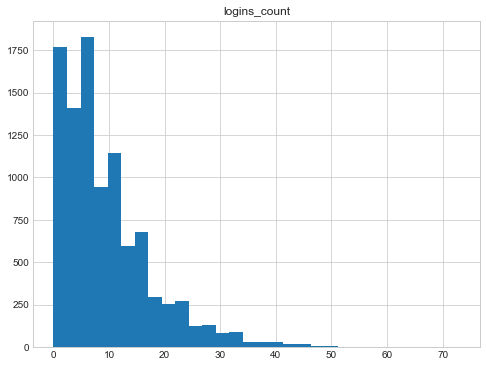

In [50]:
logins_15min_df.hist(bins=30);

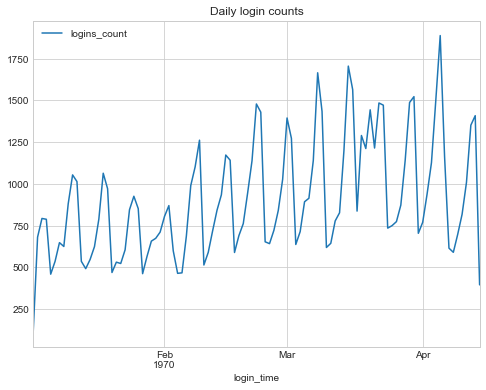

In [51]:
logins_daily_df.plot(title="Daily login counts");

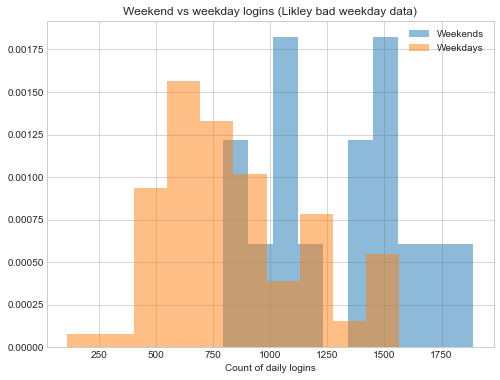

In [52]:
plt.hist(x=logins_daily_df.logins_count[logins_daily_df.is_weekend], alpha=.5,
         label="Weekends", bins=10, density=True)
plt.hist(x=logins_daily_df.logins_count[logins_daily_df.is_weekend == False], alpha=.5,
         label="Weekdays", bins=10, density=True)
plt.legend(loc='upper right')
plt.title("Weekend vs weekday logins (Likley bad weekday data)")
plt.xlabel("Count of daily logins")
plt.show()


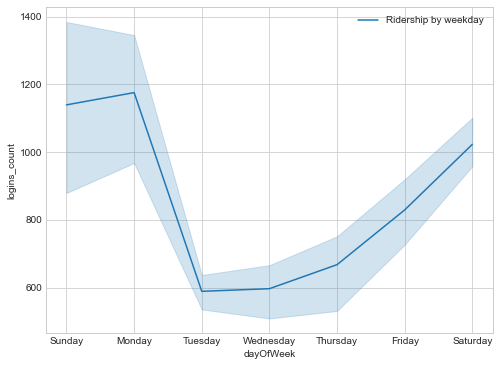

In [53]:
logins_daily_df["dayOfWeek"] = logins_daily_df.index.strftime("%A")
feb = logins_daily_df.loc['1970-2-1':'1970-2-28']
sns.lineplot(data=feb, x="dayOfWeek", y="logins_count", label="Ridership by weekday");

I would expect lower rides on weekends (or more) but it appears we see it on Tuesday and Wednesday.  I suspect the year 1970 doesn't match properly and those are actually the weekend.  This is a data issue and needs taken back to the team to correct, instead of making a assumption

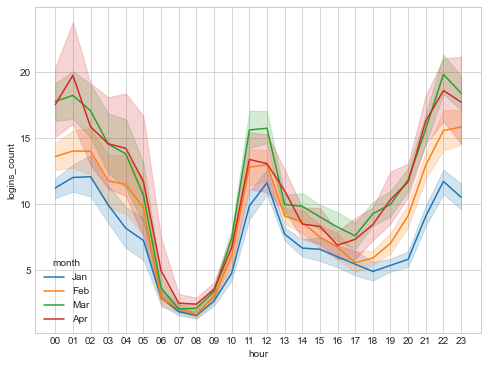

In [54]:
# add some useful features
logins_15min_df["hour"] = logins_15min_df.index.strftime("%H")
logins_15min_df["month"] = logins_15min_df.index.strftime("%b")

#Remove first partial day from set to make it sort from 0-24
logins_clip = logins_15min_df.loc["1970-01-02 00:00:00":]

sns.lineplot(data=logins_clip, x="hour", y="logins_count", hue="month", );

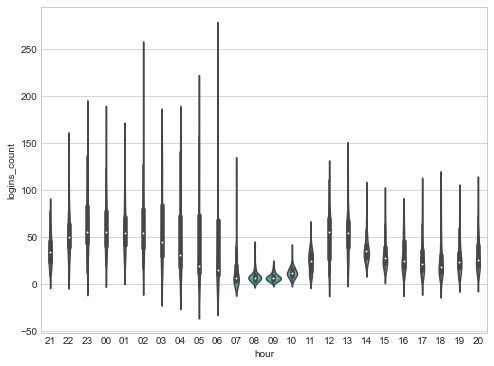

In [55]:
# Alternate viz
logins_hourly = logins_15min_df.resample('60min', label='right').sum()
logins_hourly["hour"] = logins_hourly.index.strftime("%H")
logins_hourly["month"] = logins_hourly.index.strftime("%b")
sns.violinplot(data=logins_hourly, x="hour", y="logins_count" );

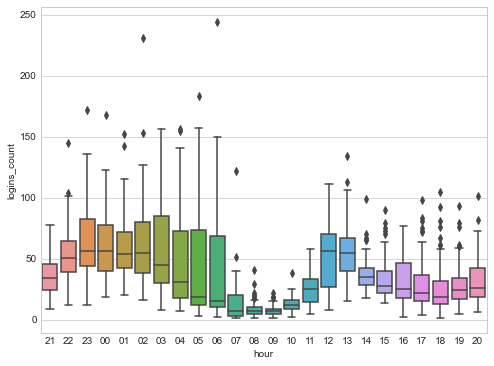

In [56]:
# alternate viz2
sns.boxplot(data=logins_hourly, x="hour", y="logins_count" );

''

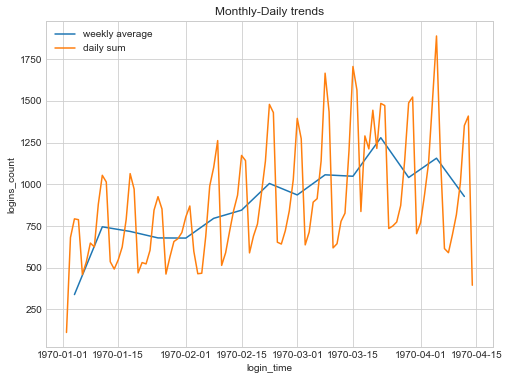

In [57]:

# resample to weekly data, then normalize to single day AND drop last week (parital week)
logins_weekly_df = (logins_df.resample('W', label='right').sum()/7)[:-1]

#plot daily and weekly trend
sns.lineplot(data=logins_weekly_df, x="login_time" , y="logins_count", label="weekly average")
sns.lineplot(data=logins_daily_df, x="login_time" , y="logins_count", label="daily sum")
plt.title("Monthly-Daily trends")
;

## Summary of EDA

### Data Quality 

In [58]:
display(logins_15min_df.head(3))

,logins_count,hour,month
login_time,,,
1970-01-01 20:15:00,2,20,Jan
1970-01-01 20:30:00,6,20,Jan
1970-01-01 20:45:00,9,20,Jan


The time stamp starts off in Jan 1st 1970.  This poses 2 issues
1. The year is wrong
2. The days of the week are probably wrong, placing weekends on weekdays.

Looking at the data, there are strong patterns in the weekly usage, so this is important to resolve!  I.e. I would expect certain trends on weekdays vs. weekends, but I think the week end is showing up on Monday-Tuesday.

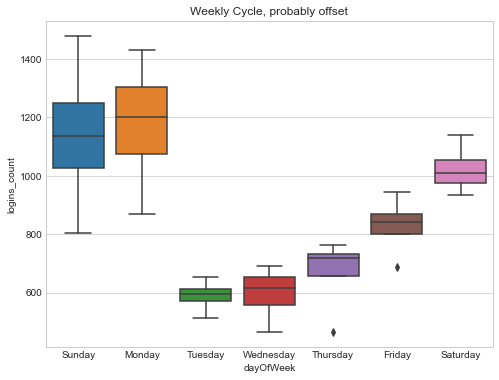

In [59]:
sns.boxplot(data=feb, x="dayOfWeek", y="logins_count")
plt.title("Weekly Cycle, probably offset");

As mentioned, I would really expect weekends to be the highest OR lowest, but with this data, it looks like Monday is the peak day, with a sharp drop to Tuesday. 

### Daily and overall trends

**Daily cycle**

Typical day:
   * Low trough of usage from 6 am - 10 am. 
   * Peak at lunch time, 11-12
   * Trough for the afternoon
   * Evening shows highest usage, peaking near/after midnight as establishments close and folks need a ride home

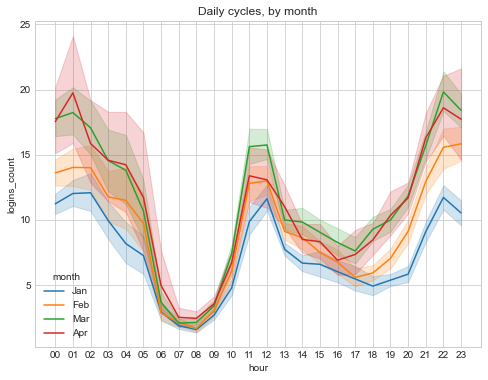

In [60]:
sns.lineplot(data=logins_clip, x="hour", y="logins_count", hue="month" )
plt.title("Daily cycles, by month");

**Overall trends**

* Sharp rise in usage in February.  Possibly due to a promotion or other business change.
* March-April we see more volatility. Higher peaks but a potential overall decline in April.
* Weekly cycle has strong consistent signal aside from something in the later half of March, maybe a holiday or event.  

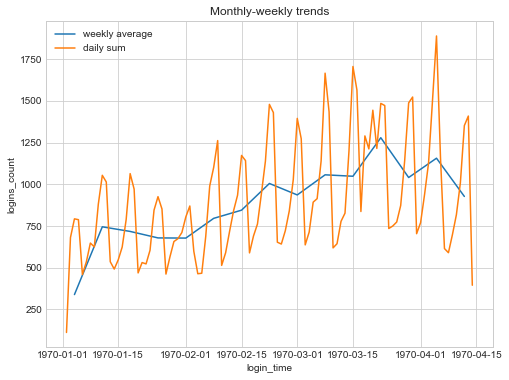

In [61]:
#plot daily and weekly trend
sns.lineplot(data=logins_weekly_df, x="login_time" , y="logins_count", label="weekly average")
sns.lineplot(data=logins_daily_df, x="login_time" , y="logins_count", label="daily sum")
plt.title("Monthly-weekly trends");

**Take home messages**
* Data has wrong year (1970)
* Strong daily cycle shows peak usage in at evening and lunch.
* Strong weekly cycle signal through entire dataset.
* More study on jump in usage at start of February, cause and potential to repeat.